In [993]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
color_pal = sns.color_palette()

In [994]:
df = pd.read_csv('analyzed_data_for_one_street.csv')
df = df.set_index('Violation Datetime')
df.index = pd.to_datetime(df.index)

In [995]:
df_1 = df.copy()

In [996]:
df_1['hour'] = df_1.index.hour
df_1["minute"] = df_1.index.minute
df_1["minute_quarter"] = pd.cut(df_1["minute"], bins=[0, 15, 30, 45, 60], labels=[1, 2, 3, 4], include_lowest=True, right=False)
df_1["minute_quarter"] = df_1["minute_quarter"].astype(int)
df_1['dayofweek'] = df_1.index.dayofweek
df_1['quarter'] = df_1.index.quarter
df_1['month'] = df_1.index.month
df_1['year'] = df_1.index.year
df_1['dayofyear'] = df_1.index.dayofyear
df_1['dayofmonth'] = df_1.index.day
df_1['weekofyear'] = df_1.index.isocalendar().week

In [997]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14803 entries, 2016-06-29 16:23:00 to 2023-09-28 03:17:00
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Issue Date          14803 non-null  object 
 1   Violation Precinct  14803 non-null  int64  
 2   Violation Time      14803 non-null  object 
 3   Street Name         14803 non-null  object 
 4   Violation_Rate      14803 non-null  float64
 5   hour                14803 non-null  int32  
 6   minute              14803 non-null  int32  
 7   minute_quarter      14803 non-null  int32  
 8   dayofweek           14803 non-null  int32  
 9   quarter             14803 non-null  int32  
 10  month               14803 non-null  int32  
 11  year                14803 non-null  int32  
 12  dayofyear           14803 non-null  int32  
 13  dayofmonth          14803 non-null  int32  
 14  weekofyear          14803 non-null  UInt32 
dtypes: UInt32(1), floa

In [998]:
df_1

,Issue Date,Violation Precinct,Violation Time,Street Name,Violation_Rate,hour,minute,minute_quarter,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Violation Datetime,,,,,,,,,,,,,,,
2016-06-29 16:23:00,06/29/2016,78,16:23,13TH STREET,20.000000,16,23,2,2,2,6,2016,181,29,26
2016-06-29 20:40:00,06/29/2016,78,20:40,13TH STREET,16.666667,20,40,3,2,2,6,2016,181,29,26
2016-06-30 08:52:00,06/30/2016,78,08:52,13TH STREET,50.000000,8,52,4,3,2,6,2016,182,30,26
2016-06-30 08:53:00,06/30/2016,78,08:53,13TH STREET,50.000000,8,53,4,3,2,6,2016,182,30,26
2016-06-30 08:55:00,06/30/2016,78,08:55,13TH STREET,50.000000,8,55,4,3,2,6,2016,182,30,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-28 03:09:00,09/28/2023,78,03:09,13TH STREET,9.803922,3,9,1,3,3,9,2023,271,28,39
2023-09-28 03:11:00,09/28/2023,78,03:11,13TH STREET,9.803922,3,11,1,3,3,9,2023,271,28,39
2023-09-28 03:13:00,09/28/2023,78,03:13,13TH STREET,9.803922,3,13,1,3,3,9,2023,271,28,39


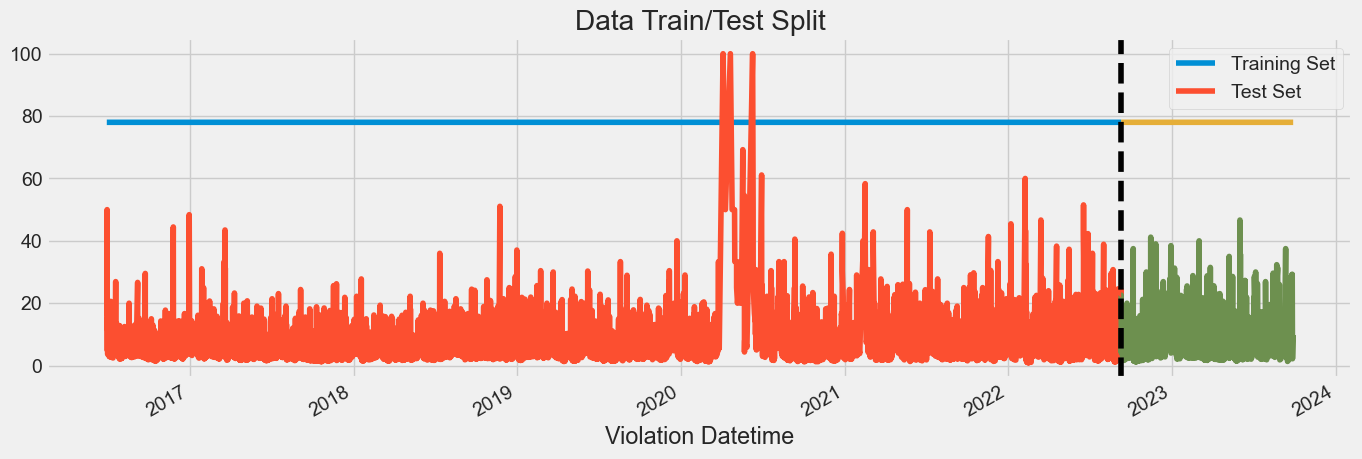

In [999]:
split_percentage = 0.85

split_index = int(len(df) * split_percentage)
train = df.iloc[:split_index]
test = df.iloc[split_index:]

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(train.index[-1], color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [1000]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*30*1, gap=24)
df_1 = df_1.sort_index()

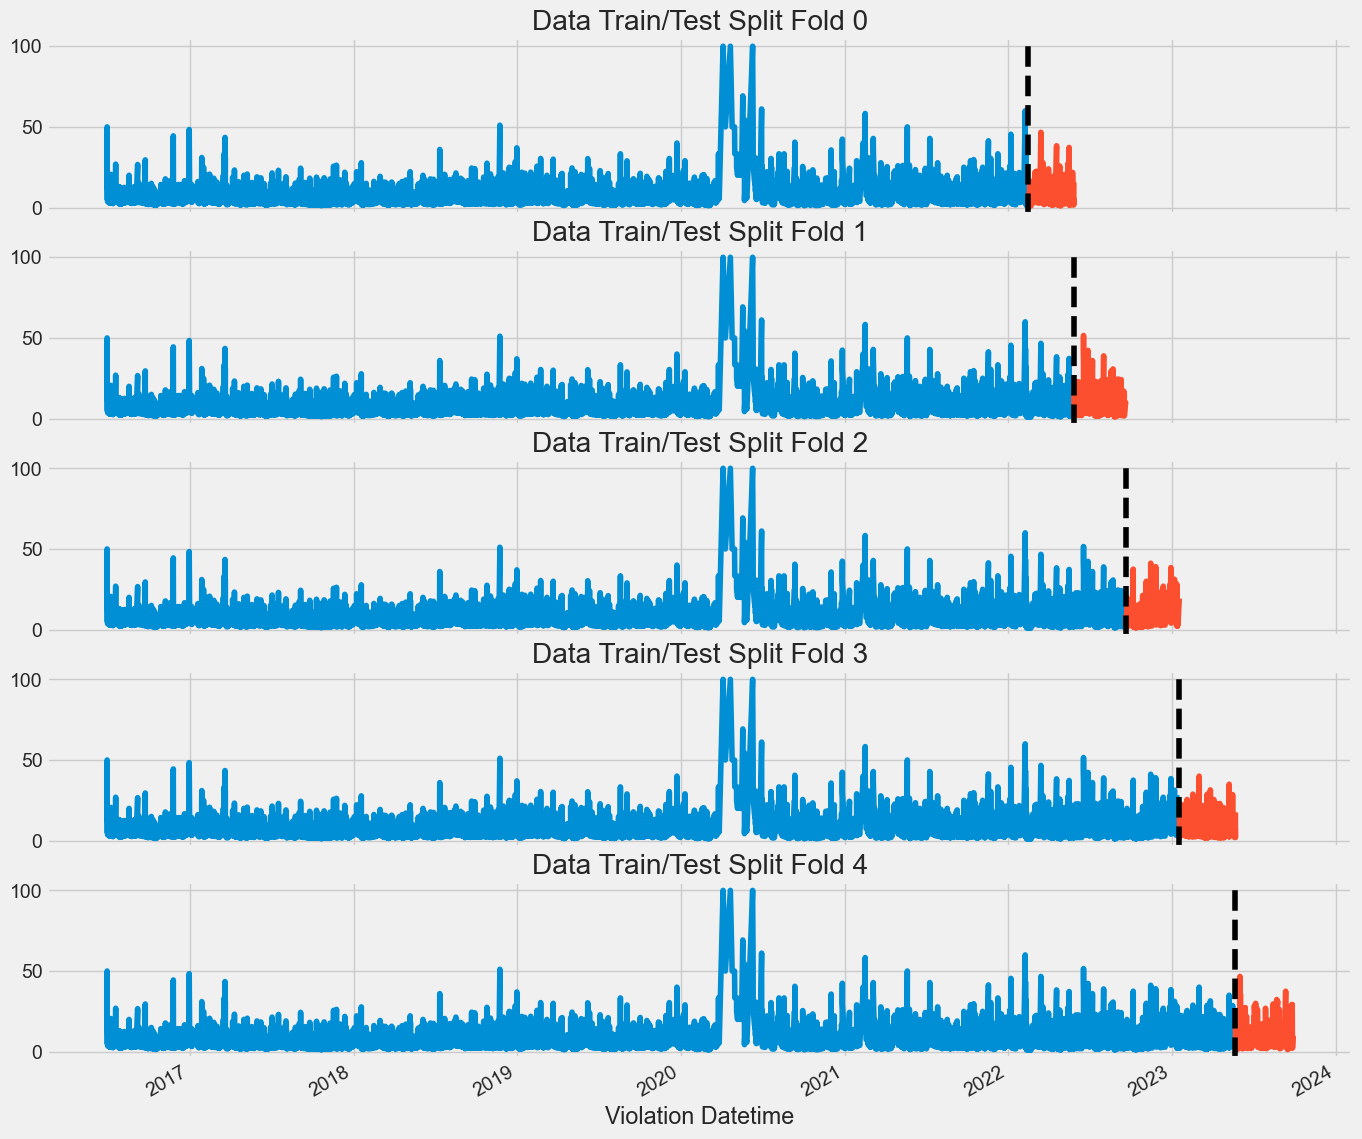

In [1001]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df_1):
    train = df_1.iloc[train_idx]
    test = df_1.iloc[val_idx]
    train['Violation_Rate'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Violation_Rate'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [1002]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df["minute"] = df.index.minute
    df["minute_quarter"] = pd.cut(df["minute"], bins=[0, 15, 30, 45, 60], labels=[1, 2, 3, 4], include_lowest=True)
    df["minute_quarter"] = df["minute_quarter"].astype(int)
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df_1 = create_features(df_1)
df_1

,Issue Date,Violation Precinct,Violation Time,Street Name,Violation_Rate,hour,minute,minute_quarter,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Violation Datetime,,,,,,,,,,,,,,,
2016-06-29 16:23:00,06/29/2016,78,16:23,13TH STREET,20.000000,16,23,2,2,2,6,2016,181,29,26
2016-06-29 20:40:00,06/29/2016,78,20:40,13TH STREET,16.666667,20,40,3,2,2,6,2016,181,29,26
2016-06-30 08:52:00,06/30/2016,78,08:52,13TH STREET,50.000000,8,52,4,3,2,6,2016,182,30,26
2016-06-30 08:53:00,06/30/2016,78,08:53,13TH STREET,50.000000,8,53,4,3,2,6,2016,182,30,26
2016-06-30 08:55:00,06/30/2016,78,08:55,13TH STREET,50.000000,8,55,4,3,2,6,2016,182,30,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-28 03:09:00,09/28/2023,78,03:09,13TH STREET,9.803922,3,9,1,3,3,9,2023,271,28,39
2023-09-28 03:11:00,09/28/2023,78,03:11,13TH STREET,9.803922,3,11,1,3,3,9,2023,271,28,39
2023-09-28 03:13:00,09/28/2023,78,03:13,13TH STREET,9.803922,3,13,1,3,3,9,2023,271,28,39


C:\Users\YSK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\YSK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\YSK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


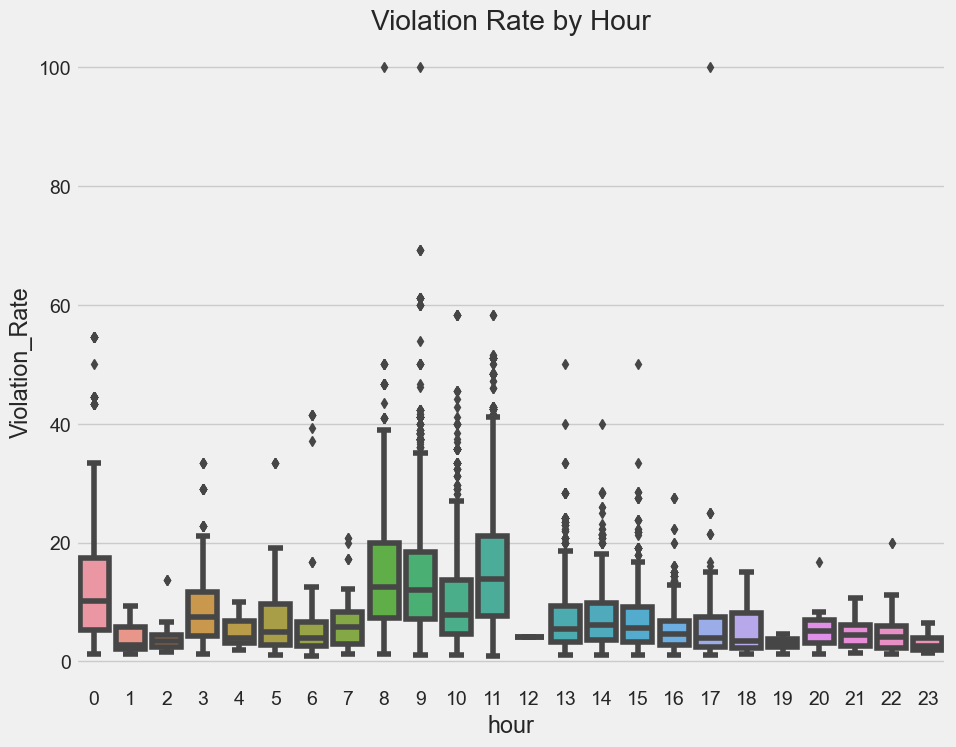

In [1003]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_1, x='hour', y='Violation_Rate', ax=ax)
ax.set_title('Violation Rate by Hour')
plt.show()

C:\Users\YSK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\YSK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\YSK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


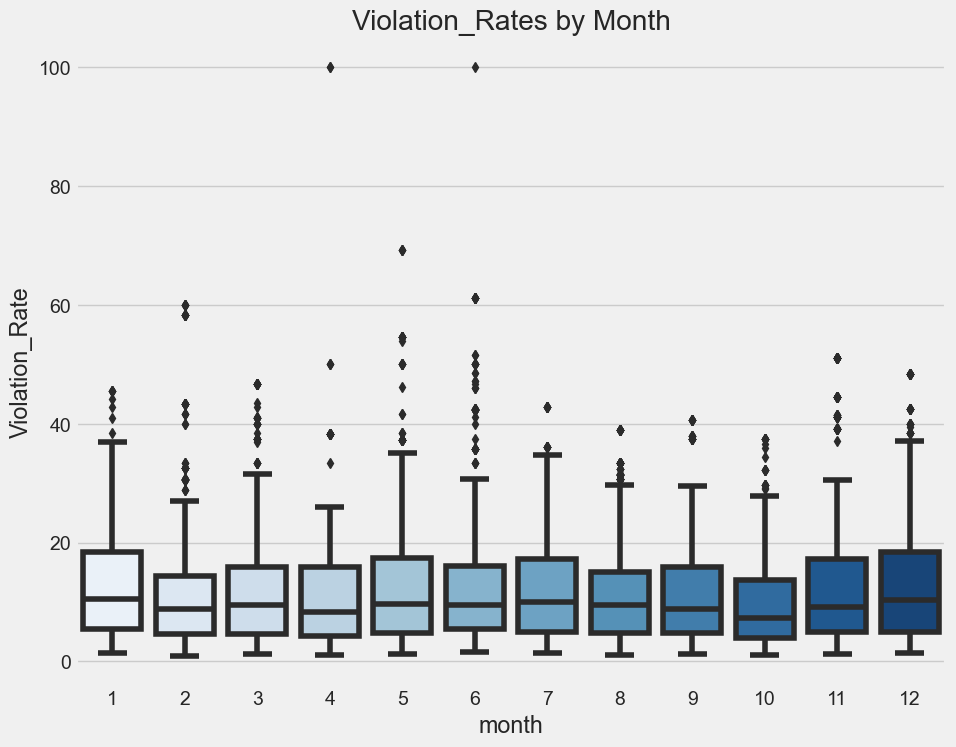

In [1004]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_1, x='month', y='Violation_Rate', palette='Blues')
ax.set_title('Violation_Rates by Month')
plt.show()

In [1005]:
def create_lag_features(data, n_lags, lag_column='Violation_Rate'):
    for i in range(1, n_lags+1):
        data[f'lag{i}'] = data[lag_column].shift(i)
    return data

n_lags = 5
df_1 = create_lag_features(df_1, n_lags, lag_column='Violation_Rate')

In [1006]:
df_1

,Issue Date,Violation Precinct,Violation Time,Street Name,Violation_Rate,hour,minute,minute_quarter,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,lag4,lag5
Violation Datetime,,,,,,,,,,,,,,,,,,,,
2016-06-29 16:23:00,06/29/2016,78,16:23,13TH STREET,20.000000,16,23,2,2,2,6,2016,181,29,26,NaN,NaN,NaN,NaN,NaN
2016-06-29 20:40:00,06/29/2016,78,20:40,13TH STREET,16.666667,20,40,3,2,2,6,2016,181,29,26,20.000000,NaN,NaN,NaN,NaN
2016-06-30 08:52:00,06/30/2016,78,08:52,13TH STREET,50.000000,8,52,4,3,2,6,2016,182,30,26,16.666667,20.000000,NaN,NaN,NaN
2016-06-30 08:53:00,06/30/2016,78,08:53,13TH STREET,50.000000,8,53,4,3,2,6,2016,182,30,26,50.000000,16.666667,20.000000,NaN,NaN
2016-06-30 08:55:00,06/30/2016,78,08:55,13TH STREET,50.000000,8,55,4,3,2,6,2016,182,30,26,50.000000,50.000000,16.666667,20.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-28 03:09:00,09/28/2023,78,03:09,13TH STREET,9.803922,3,9,1,3,3,9,2023,271,28,39,2.173913,2.222222,6.818182,6.818182,6.818182
2023-09-28 03:11:00,09/28/2023,78,03:11,13TH STREET,9.803922,3,11,1,3,3,9,2023,271,28,39,9.803922,2.173913,2.222222,6.818182,6.818182
2023-09-28 03:13:00,09/28/2023,78,03:13,13TH STREET,9.803922,3,13,1,3,3,9,2023,271,28,39,9.803922,9.803922,2.173913,2.222222,6.818182


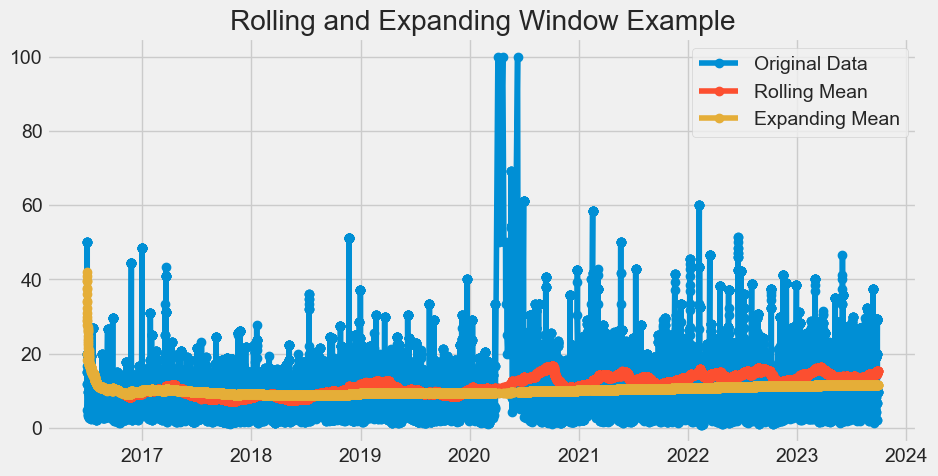

In [1007]:
window_size = 24*7*4
df_1['Rolling_Mean'] = df_1['Violation_Rate'].rolling(window=window_size).mean()
df_1['Rolling_Std'] = df_1['Violation_Rate'].rolling(window=window_size).std()

df_1['Expanding_Mean'] = df_1['Violation_Rate'].expanding().mean()
df_1['Expanding_Std'] = df_1['Violation_Rate'].expanding().std()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_1.index, df_1['Violation_Rate'], label='Original Data', marker='o')
ax.plot(df_1.index, df_1['Rolling_Mean'], label='Rolling Mean', marker='o')
ax.plot(df_1.index, df_1['Expanding_Mean'], label='Expanding Mean', marker='o')
ax.legend(loc='best')
ax.set_title('Rolling and Expanding Window Example')
plt.show()

In [1008]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*30*1, gap=24)
df_1 = df_1.sort_index()

fold = 0
preds = []
scores = []
scores_r2 = []
for train_idx, val_idx in tss.split(df_1):
    train = df_1.iloc[train_idx]
    test = df_1.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'minute_quarter', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3', 'lag4', 'lag5']
    TARGET = 'Violation_Rate'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    score_r2 = r2_score(y_test, y_pred)
    scores_r2.append(score_r2)
    scores.append(score)

[0]	validation_0-rmse:13.58120	validation_1-rmse:16.32211
[100]	validation_0-rmse:6.59845	validation_1-rmse:7.59198


C:\Users\YSK\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:49:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:4.83345	validation_1-rmse:5.18428
[300]	validation_0-rmse:4.45123	validation_1-rmse:4.64795
[400]	validation_0-rmse:4.33110	validation_1-rmse:4.49529
[500]	validation_0-rmse:4.26508	validation_1-rmse:4.41942
[600]	validation_0-rmse:4.22366	validation_1-rmse:4.38875
[700]	validation_0-rmse:4.19775	validation_1-rmse:4.37503
[800]	validation_0-rmse:4.17115	validation_1-rmse:4.36118
[900]	validation_0-rmse:4.14602	validation_1-rmse:4.35439
[999]	validation_0-rmse:4.12244	validation_1-rmse:4.33675
[0]	validation_0-rmse:13.75620	validation_1-rmse:18.23802
[100]	validation_0-rmse:6.64988	validation_1-rmse:8.47459


C:\Users\YSK\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:49:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:4.84475	validation_1-rmse:5.76572
[300]	validation_0-rmse:4.45280	validation_1-rmse:5.21207
[400]	validation_0-rmse:4.33962	validation_1-rmse:5.12296
[500]	validation_0-rmse:4.27977	validation_1-rmse:5.08072
[600]	validation_0-rmse:4.24079	validation_1-rmse:5.04362
[700]	validation_0-rmse:4.21339	validation_1-rmse:5.02783
[800]	validation_0-rmse:4.19124	validation_1-rmse:5.01518
[900]	validation_0-rmse:4.16913	validation_1-rmse:5.00341
[999]	validation_0-rmse:4.14899	validation_1-rmse:4.98885
[0]	validation_0-rmse:14.05147	validation_1-rmse:17.06069
[100]	validation_0-rmse:6.75566	validation_1-rmse:7.98359


C:\Users\YSK\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:49:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:4.89399	validation_1-rmse:5.54310
[300]	validation_0-rmse:4.49297	validation_1-rmse:5.01094
[400]	validation_0-rmse:4.37447	validation_1-rmse:4.91395
[500]	validation_0-rmse:4.31696	validation_1-rmse:4.87483
[600]	validation_0-rmse:4.27298	validation_1-rmse:4.83825
[700]	validation_0-rmse:4.24169	validation_1-rmse:4.81161
[800]	validation_0-rmse:4.21478	validation_1-rmse:4.79174
[900]	validation_0-rmse:4.19193	validation_1-rmse:4.76862
[999]	validation_0-rmse:4.17266	validation_1-rmse:4.75503
[0]	validation_0-rmse:14.22352	validation_1-rmse:15.77053
[100]	validation_0-rmse:6.81490	validation_1-rmse:7.47559


C:\Users\YSK\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:49:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:4.91637	validation_1-rmse:5.22958
[300]	validation_0-rmse:4.50611	validation_1-rmse:4.74056
[400]	validation_0-rmse:4.38881	validation_1-rmse:4.63908
[445]	validation_0-rmse:4.35874	validation_1-rmse:4.66258
[0]	validation_0-rmse:14.30953	validation_1-rmse:17.22352
[100]	validation_0-rmse:6.84614	validation_1-rmse:8.16660


C:\Users\YSK\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:49:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:4.92648	validation_1-rmse:5.72119
[300]	validation_0-rmse:4.51532	validation_1-rmse:5.18247
[400]	validation_0-rmse:4.40034	validation_1-rmse:5.04722
[500]	validation_0-rmse:4.33748	validation_1-rmse:5.01060
[600]	validation_0-rmse:4.29636	validation_1-rmse:4.99135
[700]	validation_0-rmse:4.27072	validation_1-rmse:4.98261
[800]	validation_0-rmse:4.24754	validation_1-rmse:4.97653
[900]	validation_0-rmse:4.22797	validation_1-rmse:4.97257
[999]	validation_0-rmse:4.20878	validation_1-rmse:4.96968


In [1009]:
y_pred

array([17.997826 , 18.033213 , 17.973738 , 17.364862 , 16.836376 ,
       16.836376 , 16.75607  , 16.75607  , 16.75607  , 16.75607  ,
       15.86787  ,  8.32833  ,  8.32833  ,  8.261742 ,  8.245491 ,
        6.22673  ,  5.4322586,  4.830287 ,  4.5467124,  6.5383162,
        6.5930123,  6.5217366,  6.9835644,  8.627312 ,  8.627312 ,
        8.559077 ,  8.541224 ,  6.8700643,  7.54078  ,  7.586032 ,
        7.586032 ,  7.37616  ,  7.37616  ,  6.5921216,  4.729584 ,
        5.2344456,  5.572856 ,  7.9401474,  7.843307 ,  6.885905 ,
        4.159544 ,  4.415135 ,  4.953568 ,  5.4996295,  5.4982824,
        5.696413 ,  7.0232506, 10.885878 , 10.962686 , 10.877105 ,
       10.491348 , 10.491348 , 10.491348 , 10.491348 , 10.491348 ,
        9.069352 ,  4.377717 ,  4.8937664,  4.130196 ,  3.986799 ,
        4.4885836,  6.072527 ,  5.425541 ,  6.862344 , 39.533165 ,
       47.708744 , 31.614048 , 31.252363 , 30.400717 , 35.098404 ,
       40.18085  , 16.51792  , 16.600199 , 12.29049  ,  9.1916

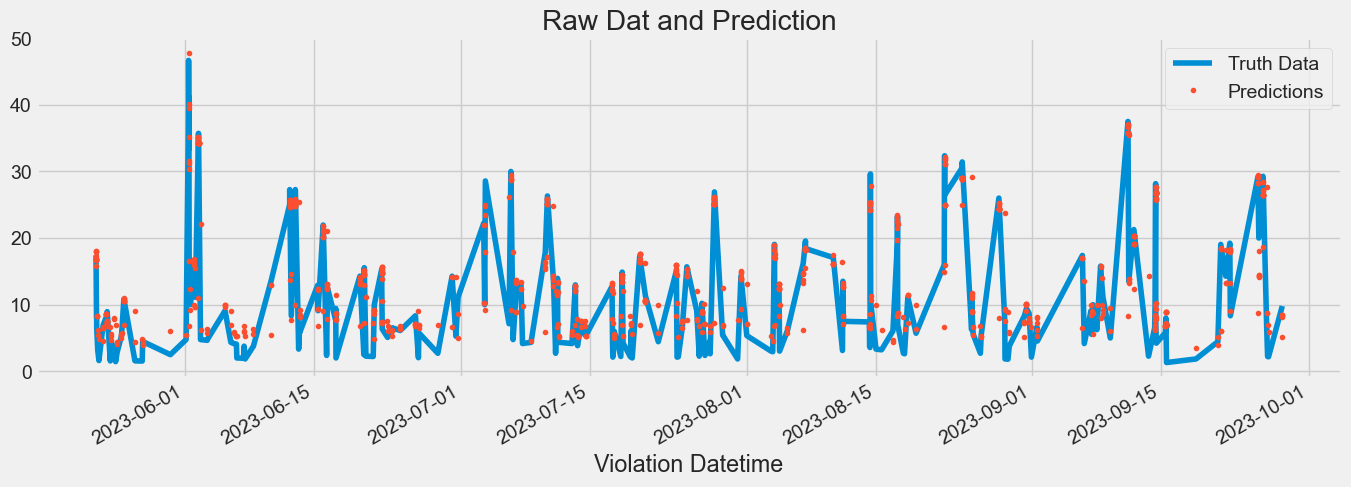

In [1010]:
test['prediction'] = y_pred
y_test_ = pd.DataFrame(y_test)
y_test_ = y_test_.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = y_test_[['Violation_Rate']].plot(figsize=(15, 5))
y_test_['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [1011]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')
print(f'R2 Score across folds {scores_r2}')
print(f'R2 Score across folds {np.mean(scores_r2):0.4f}')

Score across folds 4.7372
Fold scores:[4.336752680225872, 4.988846587095197, 4.755030024232162, 4.637048670391987, 4.9681379872783396]
R2 Score across folds [0.8243920995414048, 0.7880006830273387, 0.8044090923096578, 0.7355920649017769, 0.7354722028955274]
R2 Score across folds 0.7776


In [1012]:
def sub_plots_2(df_1, df_2, title ,m):
    fig, axes = plt.subplots(1, 2, figsize=(25,4), sharey=True, facecolor="#627D78")
    fig.suptitle(title)

    pl_1 = sns.lineplot(ax=axes[0], data=df_1, color=color_pal[m])
    axes[0].set(ylabel ="Prediction")

    pl_2 = sns.lineplot(ax=axes[1], data=df_2, color="#627D78")
    axes[1].set(ylabel ="Original")

C:\Users\YSK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\YSK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\YSK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\YSK\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_c

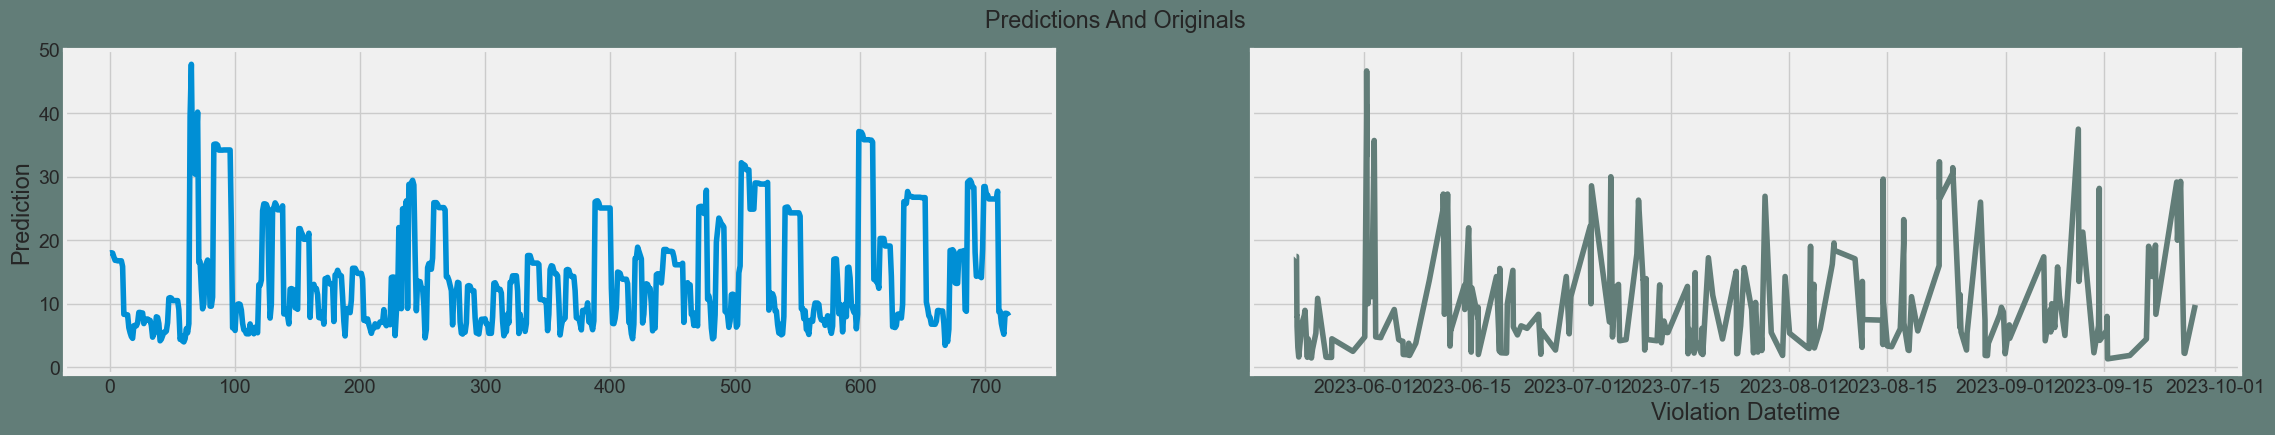

In [1013]:
sub_plots_2(y_pred, y_test ,"Predictions And Originals", 0)

In [1014]:
max_rate = df_1['Violation_Rate'].max()
df_1[df_1['Violation_Rate'] == max_rate]

,Issue Date,Violation Precinct,Violation Time,Street Name,Violation_Rate,hour,minute,minute_quarter,dayofweek,quarter,...,weekofyear,lag1,lag2,lag3,lag4,lag5,Rolling_Mean,Rolling_Std,Expanding_Mean,Expanding_Std
Violation Datetime,,,,,,,,,,,,,,,,,,,,,
2020-04-04 09:18:00,04/04/2020,78,09:18,13TH STREET,100.0,9,18,2,5,2,...,14,5.555556,11.111111,11.111111,5.263158,16.666667,10.777897,8.475720,9.493294,7.572204
2020-04-20 17:00:00,04/20/2020,78,17:00,13TH STREET,100.0,17,0,1,0,2,...,17,50.000000,100.000000,5.555556,11.111111,11.111111,10.986593,9.265359,9.510356,7.655300
2020-06-09 08:08:00,06/09/2020,78,08:08,13TH STREET,100.0,8,8,1,1,2,...,24,5.882353,6.250000,8.000000,8.000000,4.347826,12.739689,12.704525,9.672717,8.117661


In [1015]:
df_1

,Issue Date,Violation Precinct,Violation Time,Street Name,Violation_Rate,hour,minute,minute_quarter,dayofweek,quarter,...,weekofyear,lag1,lag2,lag3,lag4,lag5,Rolling_Mean,Rolling_Std,Expanding_Mean,Expanding_Std
Violation Datetime,,,,,,,,,,,,,,,,,,,,,
2016-06-29 16:23:00,06/29/2016,78,16:23,13TH STREET,20.000000,16,23,2,2,2,...,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.000000,NaN
2016-06-29 20:40:00,06/29/2016,78,20:40,13TH STREET,16.666667,20,40,3,2,2,...,26,20.000000,NaN,NaN,NaN,NaN,NaN,NaN,18.333333,2.357023
2016-06-30 08:52:00,06/30/2016,78,08:52,13TH STREET,50.000000,8,52,4,3,2,...,26,16.666667,20.000000,NaN,NaN,NaN,NaN,NaN,28.888889,18.358568
2016-06-30 08:53:00,06/30/2016,78,08:53,13TH STREET,50.000000,8,53,4,3,2,...,26,50.000000,16.666667,20.000000,NaN,NaN,NaN,NaN,34.166667,18.333333
2016-06-30 08:55:00,06/30/2016,78,08:55,13TH STREET,50.000000,8,55,4,3,2,...,26,50.000000,50.000000,16.666667,20.000000,NaN,NaN,NaN,37.333333,17.384540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-28 03:09:00,09/28/2023,78,03:09,13TH STREET,9.803922,3,9,1,3,3,...,39,2.173913,2.222222,6.818182,6.818182,6.818182,15.385726,9.766418,11.676628,9.380614
2023-09-28 03:11:00,09/28/2023,78,03:11,13TH STREET,9.803922,3,11,1,3,3,...,39,9.803922,2.173913,2.222222,6.818182,6.818182,15.392379,9.761082,11.676501,9.380310
2023-09-28 03:13:00,09/28/2023,78,03:13,13TH STREET,9.803922,3,13,1,3,3,...,39,9.803922,9.803922,2.173913,2.222222,6.818182,15.399031,9.755738,11.676375,9.380006


In [1024]:
from datetime import datetime

def categorize_minute(minute):
    if 0 <= minute <= 15:
        return 1
    elif 15 < minute <= 30:
        return 2
    elif 30 < minute <= 45:
        return 3
    else:
        return 4

def predict_violation_rate(input_date):
    input_datetime = datetime.strptime(input_date, "%Y-%m-%d %H:%M:%S")

    minute_category = categorize_minute(input_datetime.minute)

    input_features = [
        input_datetime.timetuple().tm_yday,  # dayofyear
        input_datetime.hour,
        minute_category,  # minute category
        input_datetime.weekday(),  # dayofweek
        (input_datetime.month - 1) // 3 + 1,  # quarter
        input_datetime.month,
        input_datetime.year,
        100, 100, 100, 100, 100,
    ]

    predicted_violation_rate = reg.predict([input_features])

    return predicted_violation_rate[0]

input_date = "2020-04-04 09:18:00"
predicted_rate = predict_violation_rate(input_date)
print(f"Modelin tahmini Violation Rate değeri: {predicted_rate}")

Modelin tahmini Violation Rate değeri: 59.1813850402832


In [1017]:
combined_df = pd.concat([pd.DataFrame(y_pred), y_test.reset_index(drop=True)], axis=1)
combined_df.columns = ["Pred", "Original"]

In [1018]:
combined_df

,Pred,Original
0,17.997826,17.460317
1,18.033213,17.460317
2,17.973738,17.460317
3,17.364862,17.460317
4,16.836376,17.460317
...,...,...
715,5.186006,9.803922
716,8.492042,9.803922
717,8.482594,9.803922
718,8.397013,9.803922
